In [1]:
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import seaborn as sns

from dredFISH.Utils import basicu

In [2]:
sns.set_context('talk')

In [3]:
f = '../data_dump/counts/P28_nr_allcells_Oct24.h5ad'
adata_nr = anndata.read(f)
adata_nr

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 23930 × 53547
    obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'Class_broad', 'sample', 'Type', 'Subclass'
    var: 'id'

In [4]:
f = '../data_dump/counts/P28_dr_allcells_Oct25.h5ad'
adata_dr = anndata.read(f)
adata_dr

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 24816 × 53547
    obs: 'cov', 'covfactor', 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'Type', 'Subclass'
    var: 'id'

In [5]:
adata_nr.obs['Type'].unique()

['L6CT_B', 'L4_A', 'L2/3_C', 'L4_B', 'L2/3_B', ..., 'Astro_B', 'VLMC_A', 'OD_C', 'VLMC_B', 'OPC_B']
Length: 42
Categories (42, object): ['Astro_A', 'Astro_B', 'Endo', 'Frem1', ..., 'VLMC_B', 'Vip_A', 'Vip_B', 'Vip_C']

In [6]:
adata_dr.obs['Type'].unique()

['L4_1', 'L4_2', 'L2/3_3', 'L5NP', 'L4_C', ..., 'VLMC_A', 'OD_C', 'OD_A', 'Astro_B', 'OPC_B']
Length: 42
Categories (42, object): ['Astro_A', 'Astro_B', 'Endo', 'Frem1', ..., 'VLMC_B', 'Vip_A', 'Vip_B', 'Vip_C']

In [7]:
nr_types = np.sort(adata_nr.obs['Type'].unique().astype(str))
nr_types

array(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B',
       'L2/3_C', 'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A',
       'L5PT_B', 'L6CT_A', 'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b',
       'Lamp5', 'Micro', 'OD_A', 'OD_B', 'OD_C', 'OPC_A', 'OPC_B',
       'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 'Sst_A', 'Sst_B',
       'Sst_C', 'Sst_D', 'Sst_E', 'Stac', 'VLMC_A', 'VLMC_B', 'Vip_A',
       'Vip_B', 'Vip_C'], dtype='<U7')

In [8]:
dr_types = np.sort(adata_dr.obs['Type'].unique().astype(str))
dr_types

array(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_1', 'L2/3_2',
       'L2/3_3', 'L4_1', 'L4_2', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A',
       'L5PT_B', 'L6CT_A', 'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b',
       'Lamp5', 'Micro', 'OD_A', 'OD_B', 'OD_C', 'OPC_A', 'OPC_B',
       'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 'Sst_A', 'Sst_B',
       'Sst_C', 'Sst_D', 'Sst_E', 'Stac', 'VLMC_A', 'VLMC_B', 'Vip_A',
       'Vip_B', 'Vip_C'], dtype='<U7')

In [9]:
def get_normed_bulks(mat, genes, types):
    """
    - select expressed genes
    - sparse to dense
    - merge cells to clusters
    - log10(CPM+1) norm bulk samples
    """
    ncell, ngene = mat.shape
    cellcov = np.asarray(mat.sum(axis=1)).reshape(-1,)
    genecov = np.asarray(mat.sum(axis=0)).reshape(-1,)
    cond = genecov>ncell*0.01 # expressed in at least 1% of cells
    matsub = np.asarray(mat[:,cond].todense())
    
    # pseudo-bulk samples -- pull counts from cells
    Xk, xclsts = basicu.group_sum(matsub, types)
    ck, xclsts = basicu.group_sum(cellcov.reshape(-1,1), types)
    Xk = np.log10(1+(np.array(Xk)/np.array(ck))*1e6) # log10(1+CPM)
    df = pd.DataFrame(Xk, index=xclsts, columns=genes[cond])
    return df.T # gene by types 

def get_normed_bulks_for_adata_by_types(adata):
    """
    """
    return get_normed_bulks(adata.X.copy(), adata.var.index.values, adata.obs['Type'])

In [10]:
adata_nr.obs['biosample'] = adata_nr.obs['sample'].apply(lambda x: x[:-1])
adata_dr.obs['biosample'] = adata_dr.obs['sample'].apply(lambda x: x[:-1])

In [11]:
samples_nr = np.unique(adata_nr.obs['biosample'])
samples_dr = np.unique(adata_dr.obs['biosample'])
samples_nr, samples_dr

(array(['P28_1', 'P28_2'], dtype=object),
 array(['P28_dr_1', 'P28_dr_3'], dtype=object))

In [12]:
%%time
dfs_nr = []
for samp in samples_nr:
    adatasub = adata_nr[adata_nr.obs['biosample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub)
    print(df.shape)
    print(df.columns)
    dfs_nr.append(df)

dfs_dr = []
for samp in samples_dr:
    adatasub = adata_dr[adata_dr.obs['biosample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub)
    print(df.shape)
    print(df.columns)
    dfs_dr.append(df)
    

(15727, 42)
Index(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B', 'L2/3_C',
       'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A', 'L5PT_B', 'L6CT_A',
       'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b', 'Lamp5', 'Micro', 'OD_A',
       'OD_B', 'OD_C', 'OPC_A', 'OPC_B', 'Pvalb_A', 'Pvalb_B', 'Pvalb_C',
       'Pvalb_D', 'Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E', 'Stac',
       'VLMC_A', 'VLMC_B', 'Vip_A', 'Vip_B', 'Vip_C'],
      dtype='object')
(15295, 42)
Index(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B', 'L2/3_C',
       'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A', 'L5PT_B', 'L6CT_A',
       'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b', 'Lamp5', 'Micro', 'OD_A',
       'OD_B', 'OD_C', 'OPC_A', 'OPC_B', 'Pvalb_A', 'Pvalb_B', 'Pvalb_C',
       'Pvalb_D', 'Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E', 'Stac',
       'VLMC_A', 'VLMC_B', 'Vip_A', 'Vip_B', 'Vip_C'],
      dtype='object')
(15643, 42)
Index(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_1'

In [13]:
genes_comm = adata_nr.var.index.values
for df in dfs_nr:
    genes_comm = np.intersect1d(genes_comm, df.index.values)
    print(genes_comm.shape)
for df in dfs_dr:
    genes_comm = np.intersect1d(genes_comm, df.index.values)
    print(genes_comm.shape)
    
for i in range(2):
    dfs_nr[i] = dfs_nr[i].loc[genes_comm]
    dfs_dr[i] = dfs_dr[i].loc[genes_comm]

(15727,)
(14961,)
(14683,)
(14376,)


In [14]:
# # check
# for df in dfs_nr:
#     print(df.shape, df.columns.values)
# for df in dfs_dr:
#     print(df.shape, df.columns.values)

In [15]:
tensor_nr = np.stack(dfs_nr, axis=2)
tensor_dr = np.stack(dfs_dr, axis=2)
tensor_nr.shape, tensor_dr.shape

((14376, 42, 2), (14376, 42, 2))

In [16]:
# for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
lfc = np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2) # log10FC (log10CPM as raw counts)
minexp = np.minimum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # min log10CPM 
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rejs, qs, _, _ = multipletests(np.nan_to_num(ps, 1).reshape(-1,), method='fdr_bh')
rejs = rejs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

In [17]:
lfc.shape, rejs.shape, qs.shape, np.sum(np.sum(rejs, axis=1) > 0), np.sum(rejs, axis=0) 

((14376, 42),
 (14376, 42),
 (14376, 42),
 4057,
 array([  38,  291,  195,  287,   39,   36,  107,   19,   27,   34,   31,
         112,   35,  326,  308,   31,   28,   21,   63,  127,  111,  128,
         221,  108,  567,   48, 1537,  259,  205,  458,  299,  296,  496,
         228,  425,  469, 1469,  875,  465,  414,  475,  747]))

In [18]:
sigsigs = np.logical_and(np.logical_and(rejs, (np.abs(lfc) > np.log10(2))), minexp > np.log10(1+1)) # FDR < 0.05; FC > 2; min mean CPM > 1
sigsigs.shape, np.sum(np.sum(sigsigs, axis=1) > 0), np.sum(sigsigs, axis=0)

((14376, 42),
 162,
 array([ 7,  1,  5,  8,  3, 12, 46,  1,  0,  0,  1,  1,  3,  4,  5,  2,  3,
         1,  0,  2,  2,  3,  1,  2,  8,  0,  0,  1,  3,  8,  1, 11,  5,  1,
         0,  1,  0,  1,  2,  3,  6,  1]))

In [19]:
sigsigs_up = np.logical_and(np.logical_and(rejs, (lfc > np.log10(2))), minexp > np.log10(1+1)) # FDR < 0.05; FC > 2; min mean CPM > 1
sigsigs_up.shape, np.sum(np.sum(sigsigs_up, axis=1) > 0), np.sum(sigsigs_up, axis=0)

((14376, 42),
 68,
 array([ 5,  1,  2,  1,  3,  6, 15,  0,  0,  0,  1,  0,  1,  2,  1,  2,  1,
         1,  0,  1,  2,  3,  0,  0,  0,  0,  0,  1,  0,  4,  1,  4,  5,  0,
         0,  1,  0,  1,  1,  1,  2,  0]))

In [20]:
sigsigs_dn = np.logical_and(np.logical_and(rejs, (lfc < -np.log10(2))), minexp > np.log10(1+1)) # FDR < 0.05; FC > 2; min mean CPM > 1
sigsigs_dn.shape, np.sum(np.sum(sigsigs_dn, axis=1) > 0), np.sum(sigsigs_dn, axis=0)

((14376, 42),
 94,
 array([ 2,  0,  3,  7,  0,  6, 31,  1,  0,  0,  0,  1,  2,  2,  4,  0,  2,
         0,  0,  1,  0,  0,  1,  2,  8,  0,  0,  0,  3,  4,  0,  7,  0,  1,
         0,  0,  0,  0,  1,  2,  4,  1]))

In [21]:
# show results
unq_types = dfs_nr[0].columns.values
unq_types

array(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B',
       'L2/3_C', 'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A',
       'L5PT_B', 'L6CT_A', 'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b',
       'Lamp5', 'Micro', 'OD_A', 'OD_B', 'OD_C', 'OPC_A', 'OPC_B',
       'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 'Sst_A', 'Sst_B',
       'Sst_C', 'Sst_D', 'Sst_E', 'Stac', 'VLMC_A', 'VLMC_B', 'Vip_A',
       'Vip_B', 'Vip_C'], dtype=object)

In [22]:
sigsum = pd.DataFrame(index=unq_types)
sigsum['DR_up'] = np.sum(sigsigs_up, axis=0)
sigsum['DR_dn'] = np.sum(sigsigs_dn, axis=0)
sigsum

,DR_up,DR_dn
Astro_A,5,2
Astro_B,1,0
Endo,2,3
Frem1,1,7
L2/3_A,3,0
L2/3_B,6,6
L2/3_C,15,31
L4_A,0,1
L4_B,0,0
L4_C,0,0


In [23]:
def extract_res_onetype(idx):
    return genes_comm[sigsigs_up[:,idx]], genes_comm[sigsigs_dn[:,idx]]

In [24]:
def show_onetype(idx):
    """
    """
    a = tensor_nr[sigsigs_up[:,idx],idx,:] 
    b = tensor_dr[sigsigs_up[:,idx],idx,:] 
    ab = np.hstack([a,b])

    a = tensor_nr[sigsigs_dn[:,idx],idx,:] 
    b = tensor_dr[sigsigs_dn[:,idx],idx,:] 
    ab2 = np.hstack([a,b])
    ab = np.vstack([ab,ab2])

    ab = (ab - np.mean(ab, axis=1).reshape(-1,1)) #/np.std(ab, axis=1).reshape(-1,1)
    _genes = genes_comm[np.logical_or(sigsigs_up[:,idx], sigsigs_dn[:,idx])]
    ab = pd.DataFrame(ab, 
                      index=_genes, 
                      columns=np.hstack([samples_nr, samples_dr]),
                     )
    
    fig, ax = plt.subplots(figsize=(2, min(6, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log10 FC'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [25]:
sigsum_genes = sigsum.copy()
ups = []
dns = []
for i, (_type, row) in enumerate(sigsum.iterrows()):
    _up, _dn = extract_res_onetype(i)
    ups.append(", ".join(_up))
    dns.append(", ".join(_dn))
    
sigsum_genes['genes_up'] = ups 
sigsum_genes['genes_dn'] = dns 
sigsum_genes

,DR_up,DR_dn,genes_up,genes_dn
Astro_A,5,2,"Gnpda1, Lnx2, Msrb3, Pard6a, Vps37b","BC022960, Cdkn1a"
Astro_B,1,0,Commd7,
Endo,2,3,"Tbrg4, Tmem63c","Entpd7, Slc39a2, Zfp366"
Frem1,1,7,Polr2k,"3110082I17Rik, 4930586N03Rik, Col24a1, Drc3, G..."
L2/3_A,3,0,"E230016M11Rik, Gm32647, Scg3",
L2/3_B,6,6,"Dnaja1, Dusp14, Gm13986, Gm37176, Ina, Spty2d1","Adgrd1, Gm12536, Gm42616, Mamdc2, Parp8, Scube1"
L2/3_C,15,31,"Cap1, Col23a1, Galnt17, Mapkapk2, Otof, Phyhip...","4930503L19Rik, A730056A06Rik, Arntl, Crot, Epb..."
L4_A,0,1,,Syt12
L4_B,0,0,,
L4_C,0,0,,


In [26]:
types_order = [
    'L2/3_A', 'L2/3_B', 'L2/3_C', 
    'L4_A', 'L4_B', 'L4_C', 
    'L5IT', 
    'L6IT_A', 'L6IT_B', 
    'L5PT_A', 'L5PT_B', 
    'L5NP', 
    'L6CT_A', 'L6CT_B', 'L6CT_C', 
    'L6b',
    
    'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 
    'Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E', 
    'Vip_A', 'Vip_B', 'Vip_C',
    'Lamp5', 
    
    'Stac', 
    'Frem1', 
    
    'Astro_A', 'Astro_B', 
    'OD_A', 'OD_B', 'OD_C', 
    'OPC_A', 'OPC_B',
    'Micro', 
    'Endo', 'VLMC_A', 'VLMC_B', 
]

In [27]:
dfres = sigsum_genes.loc[types_order].copy()
dfres
# dfres.to_csv('../results/P28_NR_DR_DEGs_Oct27.csv', header=True, index=True)

,DR_up,DR_dn,genes_up,genes_dn
L2/3_A,3,0,"E230016M11Rik, Gm32647, Scg3",
L2/3_B,6,6,"Dnaja1, Dusp14, Gm13986, Gm37176, Ina, Spty2d1","Adgrd1, Gm12536, Gm42616, Mamdc2, Parp8, Scube1"
L2/3_C,15,31,"Cap1, Col23a1, Galnt17, Mapkapk2, Otof, Phyhip...","4930503L19Rik, A730056A06Rik, Arntl, Crot, Epb..."
L4_A,0,1,,Syt12
L4_B,0,0,,
L4_C,0,0,,
L5IT,1,0,Nr4a2,
L6IT_A,1,0,Arhgef3,
L6IT_B,0,0,,
L5PT_A,1,2,Eprs,"Pde4c, Scube1"


In [28]:
dfplot = sigsum_genes.loc[types_order].iloc[:,:2].copy()

Text(0, 0.5, 'Number of DE genes \n (FDR<0.05, FC > 2, min CPM > 1)')

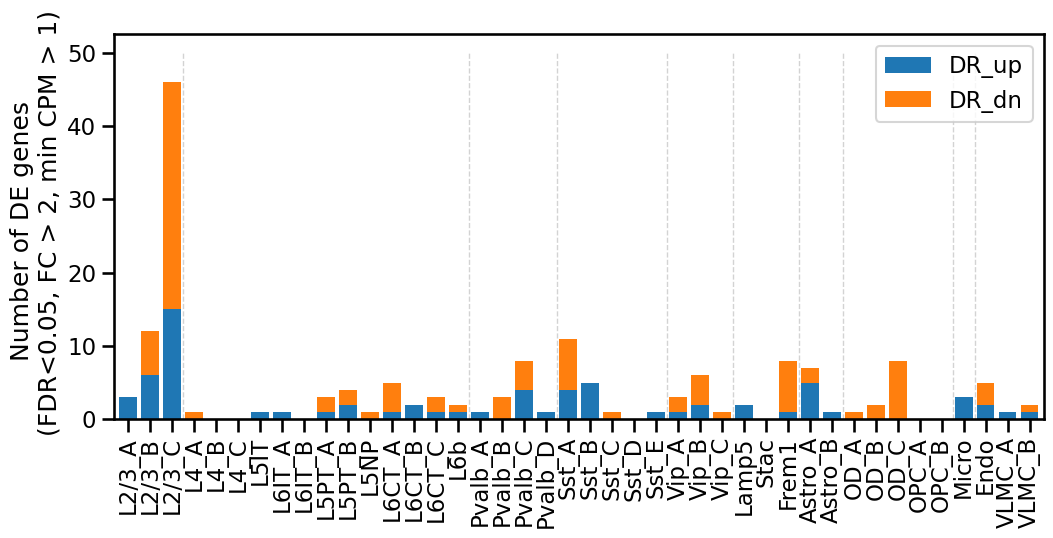

In [29]:
fig, ax = plt.subplots(figsize=(12,5))
dfplot.plot.bar(stacked=True, width=0.8, ax=ax)
ax.vlines(-0.5+np.array([3, 16, 20, 25, 28, 31, 33, 38, 39]), ymin=0, ymax=50, color='lightgray', linestyle='--', linewidth=1)
ax.set_ylabel('Number of DE genes \n (FDR<0.05, FC > 2, min CPM > 1)')

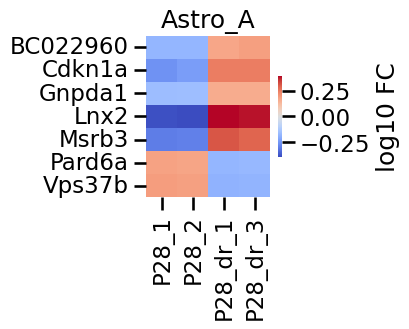

In [30]:
show_onetype(0)

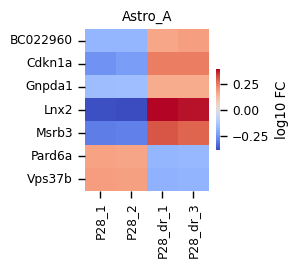

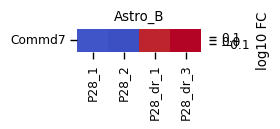

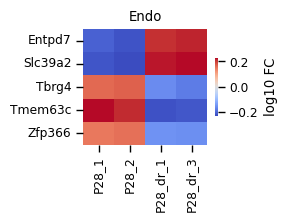

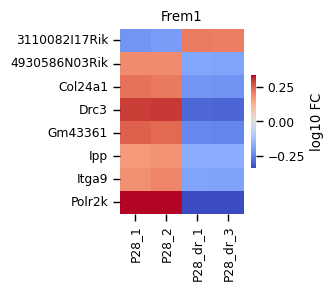

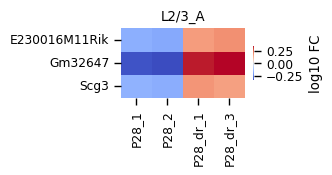

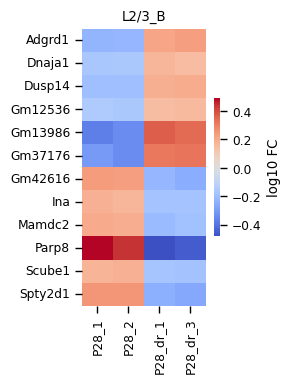

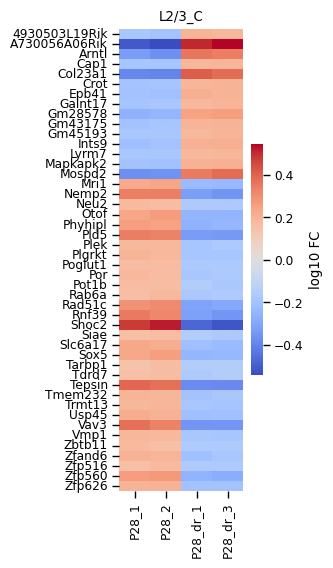

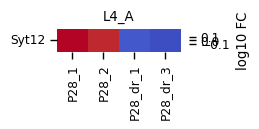

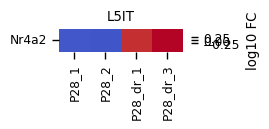

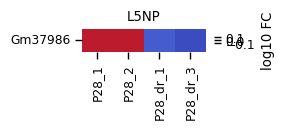

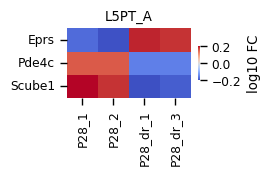

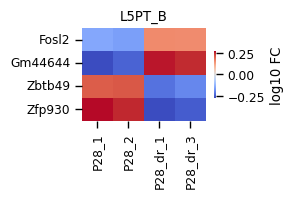

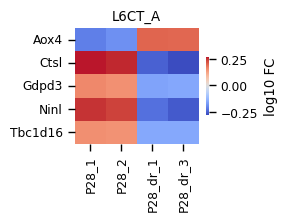

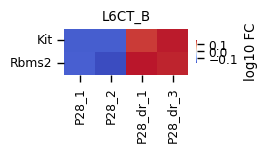

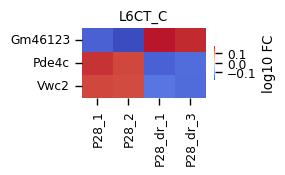

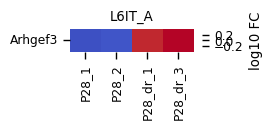

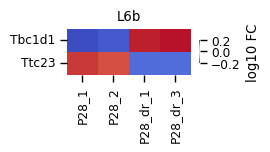

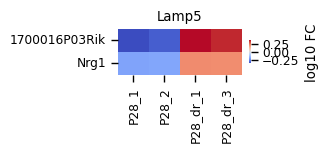

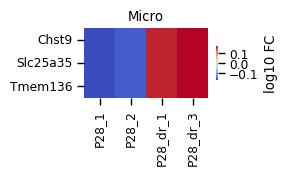

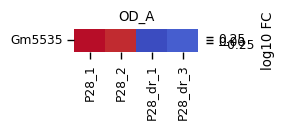

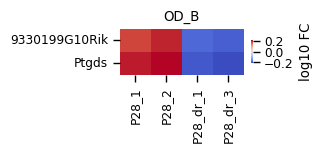

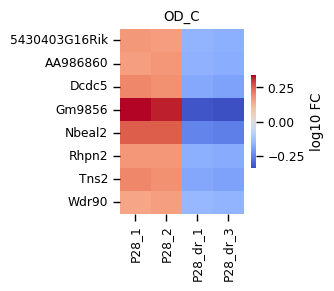

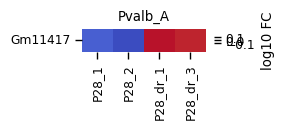

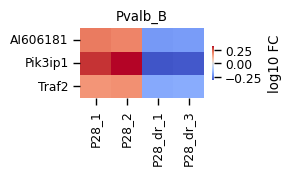

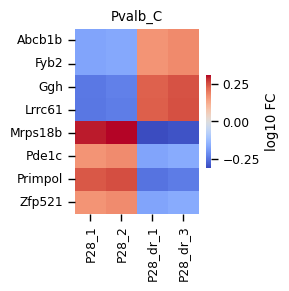

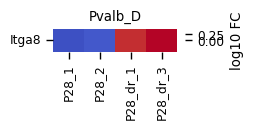

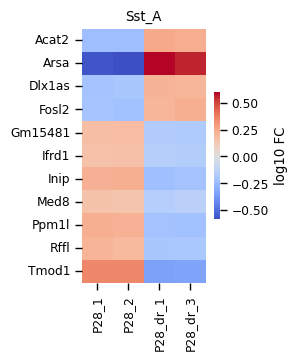

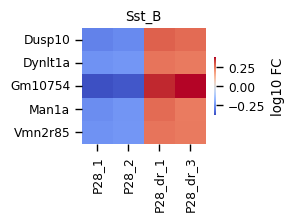

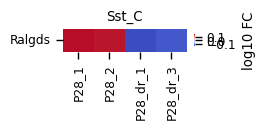

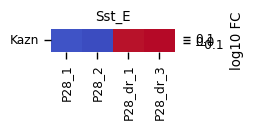

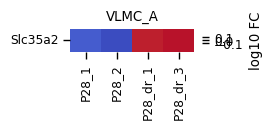

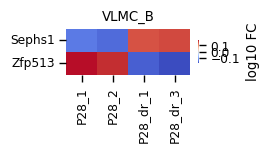

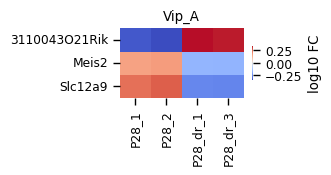

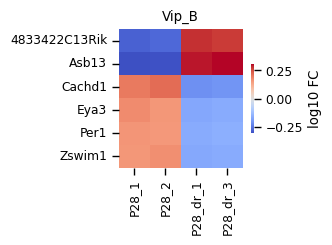

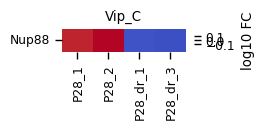

In [31]:
with sns.plotting_context('paper'):
    for i, (_type, row) in enumerate(sigsum.iterrows()):
        if row.sum() > 0:
            show_onetype(i)

In [32]:
# focus on non cells
# read the cell paper Methods?